In [109]:
library(parallel)
library(lme4)
library(mgcv)
library(xtable)

In [110]:
PATH_TO_DATA = '/Users/rachel/Documents/research/hla_ii/clean_matrices/'

Data requirements: patient tissues, patient mutations matrix, patient affinities matrix

In [111]:
get_or <- function(fit) { c(exp(c(coef(fit)[2,1],coef(fit)[2,1]-1.96*coef(fit)[2,2],coef(fit)[2,1]+1.96*coef(fit)[2,2])),coef(fit)[2,4]) }

In [116]:
#Format data
tissue <- read.csv(paste(PATH_TO_DATA, 'patient_tissues.csv', sep=""),header=TRUE)
mut <- read.csv(paste(PATH_TO_DATA, 'patient_mutations.cancer.DR.csv', sep=""),header=TRUE)
aff <- read.csv(paste(PATH_TO_DATA, 'patient_affinities.cancer.DR.csv', sep=""),header=TRUE)
patient <- as.character(mut[,1])
mut <- as.matrix(mut[,-1])
aff <- as.matrix(aff[,-1])
rownames(mut) <- rownames(aff) <- patient

In [117]:
y= as.vector(mut); x= as.vector(aff)
gene= rep(colnames(mut),each=nrow(mut))
pat= rep(rownames(mut),ncol(mut))
nmut= colSums(mut)
sel= gene %in% names(nmut[nmut>=5])

In [115]:
head(sel)

[1] TRUE TRUE TRUE TRUE TRUE TRUE

In [23]:
lme1= glmer(y[sel] ~ log(x[sel]) + (1|gene[sel]), family='binomial')
summary(lme1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(x[sel]) + (1 | gene[sel])

     AIC      BIC   logLik deviance df.resid 
 29386.7  29421.0 -14690.3  29380.7   677982 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2694 -0.0512 -0.0424 -0.0376 27.5751 

Random effects:
 Groups    Name        Variance Std.Dev.
 gene[sel] (Intercept) 0.6316   0.7947  
Number of obs: 677985, groups:  gene[sel], 165

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.17696    0.13225  -46.71   <2e-16 ***
log(x[sel])  0.02427    0.04019    0.60    0.546    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
log(x[sel]) -0.858

In [21]:
lme2= glmer(y[sel] ~ log(x[sel]) + (1|pat[sel]), family='binomial')
summary(lme2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(x[sel]) + (1 | pat[sel])

     AIC      BIC   logLik deviance df.resid 
 32414.4  32448.7 -16204.2  32408.4   677982 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.0721 -0.0646 -0.0609 -0.0562 29.1612 

Random effects:
 Groups   Name        Variance Std.Dev.
 pat[sel] (Intercept) 0        0       
Number of obs: 677985, groups:  pat[sel], 4109

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.27115    0.06695  -93.67   <2e-16 ***
log(x[sel])  0.22202    0.02083   10.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
log(x[sel]) -0.953

In [84]:
mysummarypan <- vector("list",2)
mysummarypan[[1]] <- summary(lme1)
mysummarypan[[2]] <- summary(lme2)
tabgene <- do.call(rbind,lapply(mysummarypan,get_or))
rownames(tabgene) <- c('mutation', 'patient')
colnames(tabgene) <- c('OR', "conf_OR_low", 'conf_OR_high', 'P')
write.table(tabgene, file = "../../../generated_data/pan.txt")

[[1]]
[1] 1.0245638 0.9469510 1.1085379 0.5459853

[[2]]
[1] 1.248598e+00 1.198653e+00 1.300623e+00 1.568396e-26

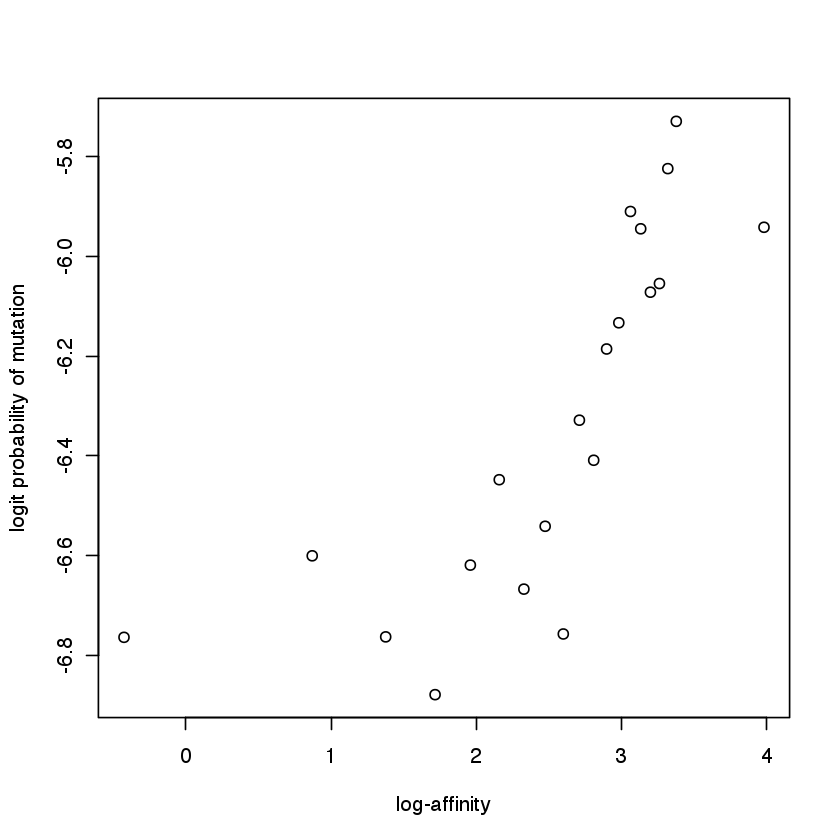

In [118]:
#thre <- c(0,0.5,1,1.5,2,2.5,3,4,5,Inf)
thre <- c(0,2,4,6,8,10,12,14,16,Inf)
xr= cut(x,breaks=thre)
m <- tapply(y,xr,'mean')
thre <- c(seq(0,30,length=20),Inf)
xr= cut(x,breaks=thre)
m <- tapply(y,xr,'mean')
plot(log(tapply(x,xr,'mean')),log(m/(1-m)),xlab='log-affinity',ylab='logit probability of mutation')

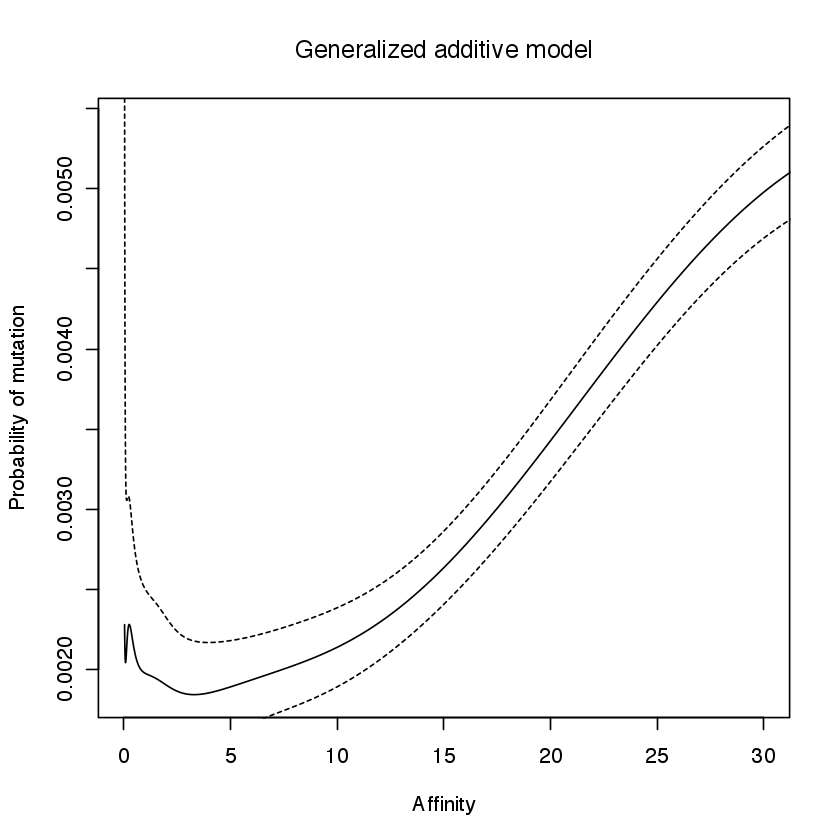

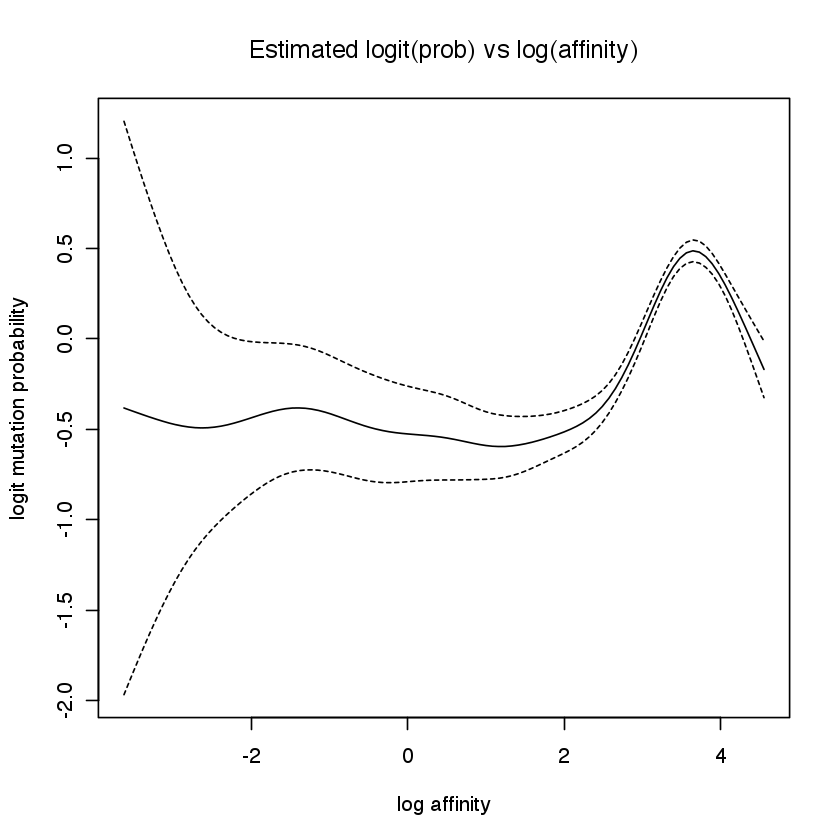

In [119]:
gam1= gam(y[sel] ~ s(log(x[sel])), family='binomial')
ypred= predict(gam1,type='response',se.fit=TRUE)
o= order(x[sel])
plot(x[sel][o],ypred$fit[o],type='l',xlim=c(0,30),xlab='Affinity',ylab='Probability of mutation',main='Generalized additive model')
lines(x[sel][o],ypred$fit[o]-1.96*ypred$se.fit[o],lty=2)
lines(x[sel][o],ypred$fit[o]+1.96*ypred$se.fit[o],lty=2)
#
plot(gam1,rug=FALSE,xlab='log affinity',ylab='logit mutation probability',main='Estimated logit(prob) vs log(affinity)')

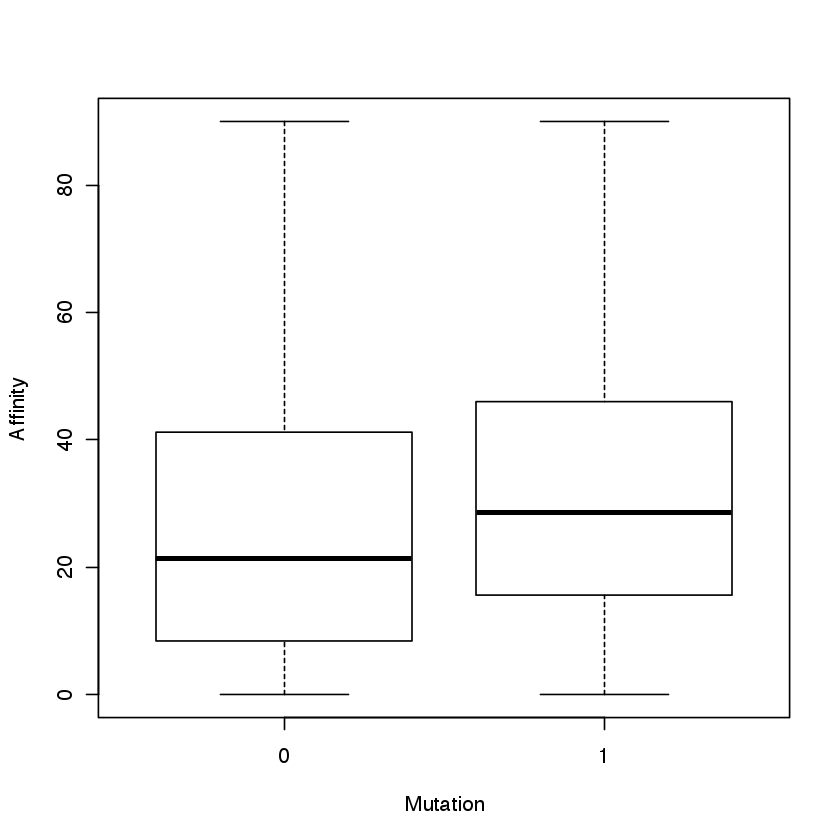

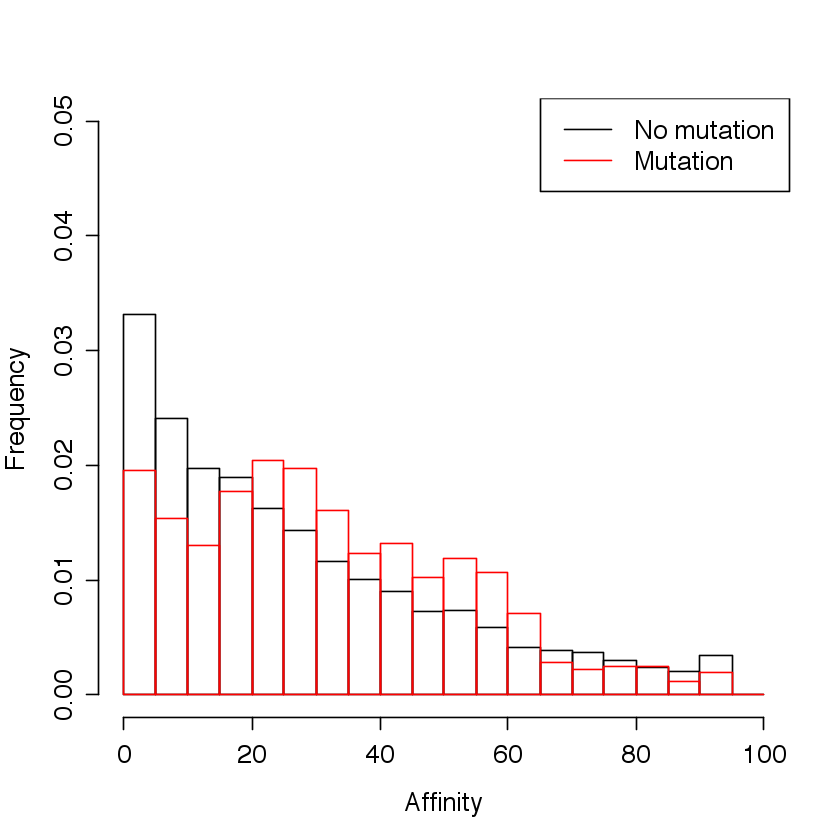

In [120]:
boxplot(x ~ y, outline=F, ylab='Affinity', xlab='Mutation')
#
hist(x[y==0],main='',xlim=c(0,100),ylim=c(0,.05),prob=T,breaks=seq(0,100,by=5),xlab='Affinity',ylab='Frequency',cex.lab=1.3,cex.axis=1.3)
par(new=TRUE)
hist(x[y==1],main='',xlim=c(0,100),ylim=c(0,.05),prob=T,breaks=seq(0,100,by=5),border=2,xaxt='n',yaxt='n',xlab='',ylab='')
legend('topright',c('No mutation','Mutation'),lty=1,col=1:2,cex=1.3)

## Panel D

In [45]:
unique(tissue[,2])

[1] MESO BRCA UCS  LUSC GBM  READ KICH COAD SKCM STAD THCA PRAD CESC BLCA UVM 
[16] ACC  LGG  UCEC TGCT OV   LAML LUAD LIHC HNSC PCPG KIRP SARC DLBC KIRC PAAD
30 Levels: ACC BLCA BRCA CESC COAD DLBC GBM HNSC KICH KIRC KIRP LAML ... UVM

In [47]:
y= as.vector(mut); x= as.vector(aff)
gene= rep(colnames(mut),each=nrow(mut))
pat= rep(rownames(mut),ncol(mut))
nmut= colSums(mut)
genesel= (gene %in% names(nmut[nmut>=5]))

In [48]:
#tissuetypes <- as.character(unique(tissue[,2]))
tissuetypes <- c('MESO', 'BRCA', 'UCS', 'LUSC', 'GBM', 'READ', 'KICH', 'COAD', 'SKCM', 'STAD', 'THCA', 'PRAD', 'CESC', 'BLCA', 'UVM', 'ACC', 'LGG', 'UCEC', 'TGCT', 'OV', 'LAML', 'LUAD', 'LIHC', 'HNSC', 'PCPG', 'KIRP', 'DLBC', 'KIRC', 'PAAD')
mysummary0 <- mysummary1 <- mysummary2 <- vector("list",length(tissuetypes))
names(mysummary0) <- names(mysummary1) <- names(mysummary2) <- tissuetypes
for (i in 1:length(tissuetypes)) {
    message("TISSUE",tissuetypes[i])
    #
    patsel= pat %in% as.character(tissue$Sample[tissue$Tissue==tissuetypes[i]])
    sel= genesel & patsel
    #
    lme0= glm(y[sel] ~ log(x[sel]), family='binomial')
    mysummary0[[i]] <- summary(lme0)
    #
    lme1= glmer(y[sel] ~ log(x[sel]) + (1|gene[sel]), family='binomial')
    mysummary1[[i]] <- summary(lme1)
    #
    lme2= glmer(y[sel] ~ log(x[sel]) + (1|pat[sel]), family='binomial')
    mysummary2[[i]] <- summary(lme2)
    message("Done \n")
}

TISSUEMESO
Done 

TISSUEBRCA
Done 

TISSUEUCS
Done 

TISSUELUSC
Done 

TISSUEGBM
Done 

TISSUEREAD
Done 

TISSUEKICH
Done 

TISSUECOAD
Done 

TISSUESKCM
Done 

TISSUESTAD
Done 

TISSUETHCA
Done 

TISSUEPRAD
Done 

TISSUECESC
Done 

TISSUEBLCA
Done 

TISSUEUVM
Done 

TISSUEACC
Done 

TISSUELGG
Done 

TISSUEUCEC
Done 

TISSUETGCT
Done 

TISSUEOV
Done 

TISSUELAML
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0648605 (tol = 0.001, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”Done 

TISSUELUAD
Done 

TISSUELIHC
Done 

TISSUEHNSC
Done 

TISSUEPCPG
Done 

TISSUEKIRP
Done 

TISSUEDLBC
Done 

TISSUEKIRC
Done 

TISSUEPAAD
Done 



In [49]:
mysummary2['THCA']

$THCA
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(x[sel]) + (1 | pat[sel])

     AIC      BIC   logLik deviance df.resid 
  2117.5   2143.2  -1055.7   2111.5    38937 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.119 -0.078 -0.061 -0.045 38.057 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 pat[sel] (Intercept) 4.518e-15 6.721e-08
Number of obs: 38940, groups:  pat[sel], 236

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -8.2097     0.3809 -21.555  < 2e-16 ***
log(x[sel])   0.8679     0.1066   8.141 3.93e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
log(x[sel]) -0.979


In [50]:
coef(mysummary2['HNSC'])

NULL

In [51]:
tabgene <- do.call(rbind,lapply(mysummary1,get_or))
tabpat <- do.call(rbind,lapply(mysummary2,get_or))
xtable(tabgene[order(rownames(tabgene)),],digits=c(0,3,3,3,4))
xtable(tabpat[order(rownames(tabpat)),],digits=c(0,3,3,3,4))
npat <- table(tissue$Tissue)

,1,2,3,4
ACC,0.5532264,0.2470748,1.238732,0.15002656
BLCA,1.1124303,0.8612666,1.436839,0.41445720
BRCA,1.0271140,0.6461686,1.632644,0.90991737
CESC,0.7687909,0.5031971,1.174568,0.22401258
COAD,1.0902948,0.8736604,1.360646,0.44431998
DLBC,1.3809119,0.3046115,6.260164,0.67556639
GBM,1.2037753,0.8673267,1.670737,0.26746421
HNSC,1.1096676,0.8869951,1.388240,0.36249264
KICH,3.7238501,0.9171019,15.120523,0.06592099
KIRC,0.6593018,0.2730728,1.591806,0.35428768


,1,2,3,4
ACC,1.1094586,0.6108218,2.015151,7.330114e-01
BLCA,1.2141275,1.0118905,1.456784,3.687428e-02
BRCA,1.0215300,0.8305416,1.256437,8.401388e-01
CESC,0.7687912,0.5031963,1.174571,2.240153e-01
COAD,1.1355335,1.0048246,1.283245,4.163591e-02
DLBC,1.3809119,0.3045920,6.260565,6.755794e-01
GBM,1.6678277,1.3380696,2.078852,5.336278e-06
HNSC,1.1299571,0.9795430,1.303468,9.365937e-02
KICH,3.7238494,0.9169946,15.122286,6.594358e-02
KIRC,0.6593018,0.2730610,1.591874,3.543112e-01


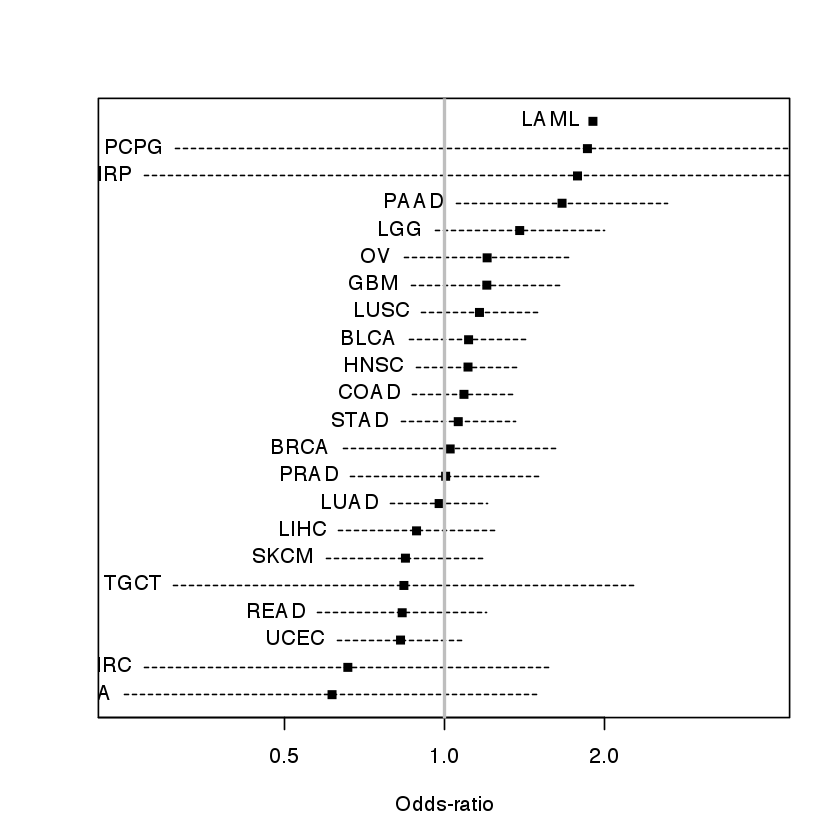

In [52]:
x2plot <- tabgene[order(tabgene[,1]),]
x2plot <- x2plot[rownames(x2plot) %in% names(npat[npat>=100]), ]
plot(x2plot[,1],1:nrow(x2plot),pch=15,xlim=c(0.25,4),yaxt='n',ylab='',xlab='Odds-ratio',log='x')
segments(x0=x2plot[,2],x1=x2plot[,3],1:nrow(x2plot),lty=2)
text(x2plot[,2],1:nrow(x2plot),rownames(x2plot),pos=2)
abline(v=1,col='gray',lwd=2)

## Panel E

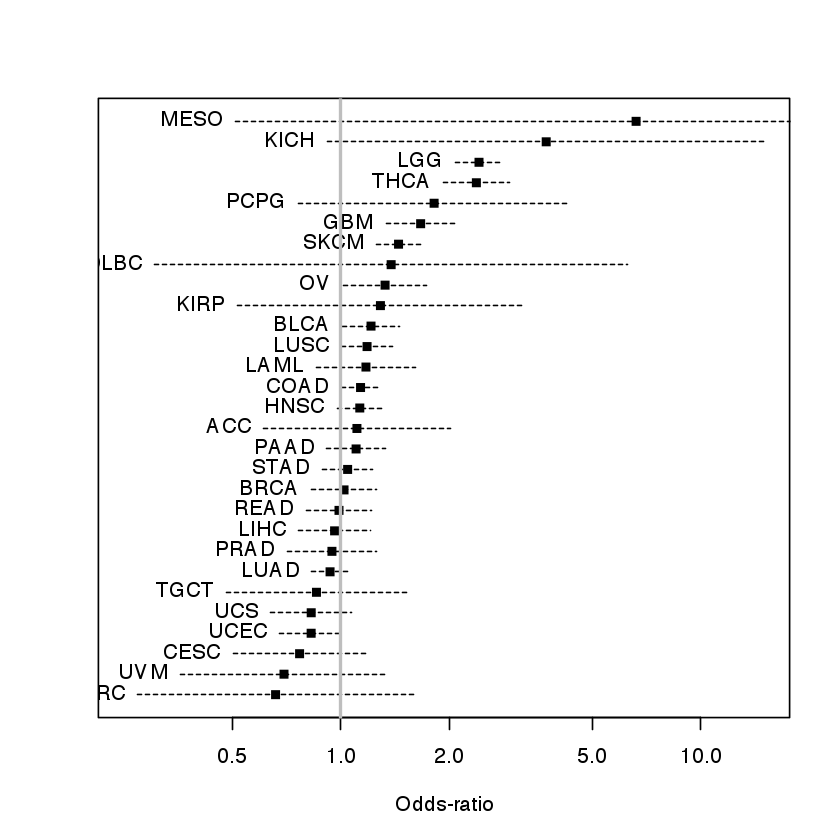

In [53]:
x2plot <- tabpat[order(tabpat[,1]),]
#x2plot <- x2plot[rownames(x2plot) %in% names(npat[npat>=100]), ]

x2plot <- x2plot[rownames(x2plot) %in% names(npat), ]
plot(x2plot[,1],1:nrow(x2plot),pch=15,xlim=c(0.25,15),yaxt='n',ylab='',xlab='Odds-ratio',log='x')
segments(x0=x2plot[,2],x1=x2plot[,3],1:nrow(x2plot),lty=2)
text(x2plot[,2],1:nrow(x2plot),rownames(x2plot),pos=2)
abline(v=1,col='gray',lwd=2)